In [119]:
import pandas as pd
import numpy as np
from datetime import datetime
import json
import seaborn as sns

In [6]:
df_edn_level = pd.read_csv('../raw-data/Kiron Supplementary Data.xlsx - Educational Level of Migrants.csv')
df_over_qual = pd.read_csv('../raw-data/Kiron Supplementary Data.xlsx - Over qualification.csv')
df_popn = pd.read_csv('../raw-data/Kiron Supplementary Data.xlsx - Population in Education.csv')

In [265]:
class DataProcessing():
    
    def __init__(self):
       """
       """
    def clean(self, df):
        
        df = df.rename(columns=lambda x: x.strip()) # remove trailing whitespaces from column names
        
        # clean up 'attended_university' categorization
        df['attended_university'] = df['attended_university'].replace('TRUE\t', 'TRUE')
        df['attended_university'] = df['attended_university'].replace('FALSE\t', 'FALSE')
        df['attended_university'] = df['attended_university'].replace('\t', 'UNKNOWN')
        df['attended_university'] = df['attended_university'].fillna('UNKNOWN')
        
        # Replace country names to match geo.json file 
        df['nationality'] = df['nationality'].replace('Syrian Arab Republic', 'Syria')
        df['nationality'] = df['nationality'].replace('Iran (Islamic Republic of)', 'Iran')
        df['nationality'] = df['nationality'].replace('Palestine, State of', 'Palestine')
        df['nationality'] = df['nationality'].replace('Congo (Democratic Republic of the)', 'Dem. Rep. Congo')
        df['nationality'] = df['nationality'].replace('Russian Federation', 'Russia')
        df['nationality'] = df['nationality'].replace('Venezuela (Bolivarian Republic of)', 'Venezuela')
        df['nationality'] = df['nationality'].replace('Tanzania\tUnited Republic of', 'Tanzania')
        df['nationality'] = df['nationality'].replace('United Kingdom of Great Britain and Northern Ireland', 'United Kingdom')
        df['nationality'] = df['nationality'].replace("C√¥te d'Ivoire", "Côte d'Ivoire")
        df['nationality'] = df['nationality'].replace('United States of America', 'United States')
        df['nationality'] = df['nationality'].replace('South Sudan', 'S. Sudan')
        df['nationality'] = df['nationality'].replace('Western Sahara', 'W. Sahara')
        
        # student_since: convert string dates to datetime format
        df['student_since'] = df['student_since'].apply(lambda x : datetime.strptime(x,  "%m/%d/%Y"))
        df = df.sort_values('student_since', ascending=True)
        
        # student_since: label datetime by year, month, semester
        df['year'] = df['student_since'].dt.year
        df['month'] = df['student_since'].dt.month
        df["semester"] =(df.month.astype(int) - 1) // 6
        df["semester"] = np.where(df['semester']==0, '1H', '2H')
                                  
        # gender: there are some students with 'other' gender. Replace with 'male'
        df['gender'] = np.where(df['gender']=='other', 'male', df['gender'])
        
        return df.reset_index()

    def aggregate_count(self, df):

        g = df.groupby('nationality')['index'].count()
        country_count = pd.DataFrame(g).reset_index().rename(columns={'index': 'count'})
        country_pcts = pd.DataFrame(g).apply(lambda x: 100 * x / float(x.sum())).reset_index().rename(columns={'index': 'pct'})
        country_stats = pd.merge(country_count, country_pcts, on='nationality', how='left')
        country_stats = country_stats.rename(columns={'nationality': 'country'})
        
        return country_stats.sort_values('pct', ascending=False)
  
    def rollup_time_count(self, df, groupby_list):

        df_time = pd.DataFrame(df.groupby(groupby_list)['student_since'].count()).reset_index()

        df_time['rollup'] = df_time.loc[0, 'student_since']
        for i,row in df_time.iterrows():
            try:
                df_time.loc[i+1, 'rollup'] = df_time.loc[i, 'rollup'] + df_time.loc[i+1, 'student_since'] 
            except:
                pass

        df_time['time'] = df_time.apply(lambda row: str(row['year']) + '-' + str(row['semester']), axis=1)

        return df_time
    
    def rollup_time_count(self, df, groupby_list):
        
        df_time_new = pd.DataFrame()
        df_time = pd.DataFrame(df.groupby(groupby_list)['student_since'].count()).reset_index() 
        
        categories = df_time[groupby_list[-1]].unique()
        for i in categories:
            df_timeF =df_time[df_time[groupby_list[-1]]==i].reset_index()
            df_timeF['rollup'] = df_timeF.loc[0, 'student_since']
            for i,row in df_timeF.iterrows():
                try:
                    df_timeF.loc[i+1, 'rollup'] = df_timeF.loc[i, 'rollup'] + df_timeF.loc[i+1, 'student_since'] 
                except:
                    pass
            df_time_new = pd.concat([df_time_new, df_timeF])
            
        df_time_new['time'] = df_time_new.apply(lambda row: str(row['year']) + '-' + str(row['semester']), axis=1)

        return df_time_new
    
    def country_edn_pct(self, df):
    
        country_edn_stats = df.groupby(['nationality', 'attended_university']).agg({'student_since': 'count'})
        country_edn_stats = country_edn_stats.groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).reset_index().rename(columns={'student_since': 'pct'})
        country_edn_stats = country_edn_stats.rename(columns={'nationality': 'country'})
        
        return country_edn_stats


In [266]:
df_students = pd.read_csv('../raw-data/kiron_students_cleaned.xlsx - kiron students cleaned.csv')
dp = DataProcessing()
df_students_clean = dp.clean(df_students)
country_stats = dp.aggregate_count(df_students_clean)
semester_stats = dp.rollup_time_count(df_students_clean, ['year', 'semester'])
semester_gender_stats = dp.rollup_time_count(df_students_clean, ['year', 'semester', 'gender'])
semester_uni_edn_stats = dp.rollup_time_count(df_students_clean, ['year', 'semester', 'attended_university'])
country_edn_stats = dp.country_edn_pct(df_students_clean)

In [269]:
top_countries = list(country_stats[0:10].country.unique())
country_edn_stats = country_edn_stats[country_edn_stats['country'].isin(top_countries)]

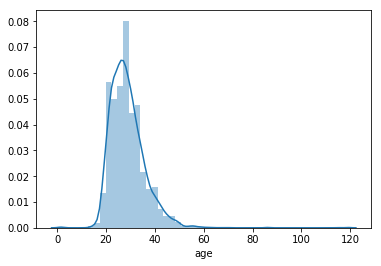

In [153]:
sns.distplot(df_students_clean['age'])

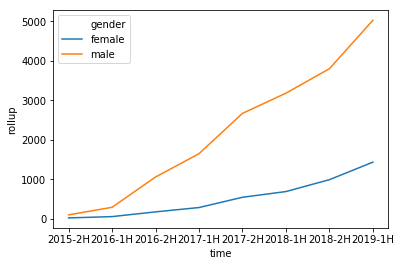

In [220]:
sns.lineplot(x='time', y='rollup', hue='gender', data=semester_gender_stats)

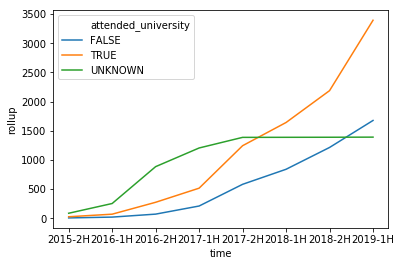

In [224]:
sns.lineplot(x='time', y='rollup', hue='attended_university', data=semester_uni_edn_stats)

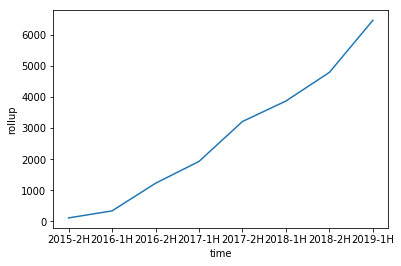

In [209]:
sns.lineplot(x='time', y='rollup', data=semester_stats)

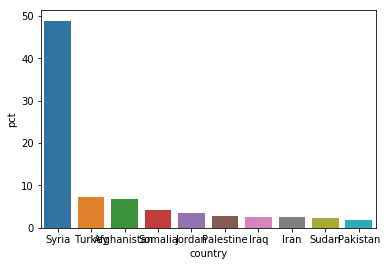

In [213]:
sns.barplot(x='country', y='pct', data=country_stats[0:10])

In [212]:
country_stats[0:10]

,country,count,pct
85,Syria,3156,48.854489
92,Turkey,474,7.337461
0,Afghanistan,439,6.795666
78,Somalia,278,4.303406
46,Jordan,227,3.513932
67,Palestine,184,2.848297
43,Iraq,166,2.569659
42,Iran,165,2.554180
81,Sudan,152,2.352941
65,Pakistan,115,1.780186


In [270]:
df_students_clean.to_csv('students_processed.csv', index=False)
country_stats.to_csv('country_stats.csv', index=False)
semester_gender_stats.to_csv('semester_gender_stats.csv', index=False)
country_edn_stats.to_csv('country_edn_stats.csv', index=False)

In [271]:
country_edn_stats

,country,attended_university,pct
0,Afghanistan,FALSE,36.446469
1,Afghanistan,TRUE,26.879271
2,Afghanistan,UNKNOWN,36.674260
84,Iran,FALSE,34.545455
85,Iran,TRUE,48.484848
86,Iran,UNKNOWN,16.969697
87,Iraq,FALSE,25.301205
88,Iraq,TRUE,46.385542
89,Iraq,UNKNOWN,28.313253
92,Jordan,FALSE,36.123348


In [26]:
with open('../raw-data/map.geo.json') as json_file:  
    map_data = json.load(json_file)

In [27]:
for i in map_data['features']:
    print(i['properties']['name'])

Barbados
Bahamas
Belize
Aruba
Bermuda
St-Barthélemy
Antigua and Barb.
Anguilla
Costa Rica
Curaçao
Dominica
Grenada
Dominican Rep.
Cayman Is.
Guatemala
Cuba
Jamaica
Honduras
Saint Lucia
Haiti
Greenland
St-Martin
St. Kitts and Nevis
Montserrat
Mexico
Nicaragua
El Salvador
Puerto Rico
St. Pierre and Miquelon
Turks and Caicos Is.
Canada
Sint Maarten
Panama
Trinidad and Tobago
British Virgin Is.
St. Vin. and Gren.
Argentina
Bolivia
U.S. Virgin Is.
Ecuador
Colombia
Brazil
Chile
Falkland Is.
Guyana
United States
Peru
Suriname
Venezuela
Afghanistan
Uruguay
Azerbaijan
United Arab Emirates
Armenia
Paraguay
Bangladesh
Bahrain
Brunei
Bhutan
N. Cyprus
Cyprus
Georgia
Hong Kong
Iran
China
Indian Ocean Ter.
Israel
Iraq
Jordan
Japan
India
Indonesia
Siachen Glacier
Cambodia
Kuwait
Kyrgyzstan
Lao PDR
Lebanon
Korea
Sri Lanka
Kazakhstan
Macao
Mongolia
Nepal
Malaysia
Oman
Pakistan
Philippines
Myanmar
Palestine
Dem. Rep. Korea
Qatar
Saudi Arabia
Singapore
Syria
Thailand
Tajikistan
Timor-Leste
Turkmenistan
Tu